In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from astropy.timeseries import TimeSeries
import astropy.units as u
from astropy.time import Time, TimeDelta
import corner
import pickle
import os
import multiprocessing
import warnings

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

#dynesty setup
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

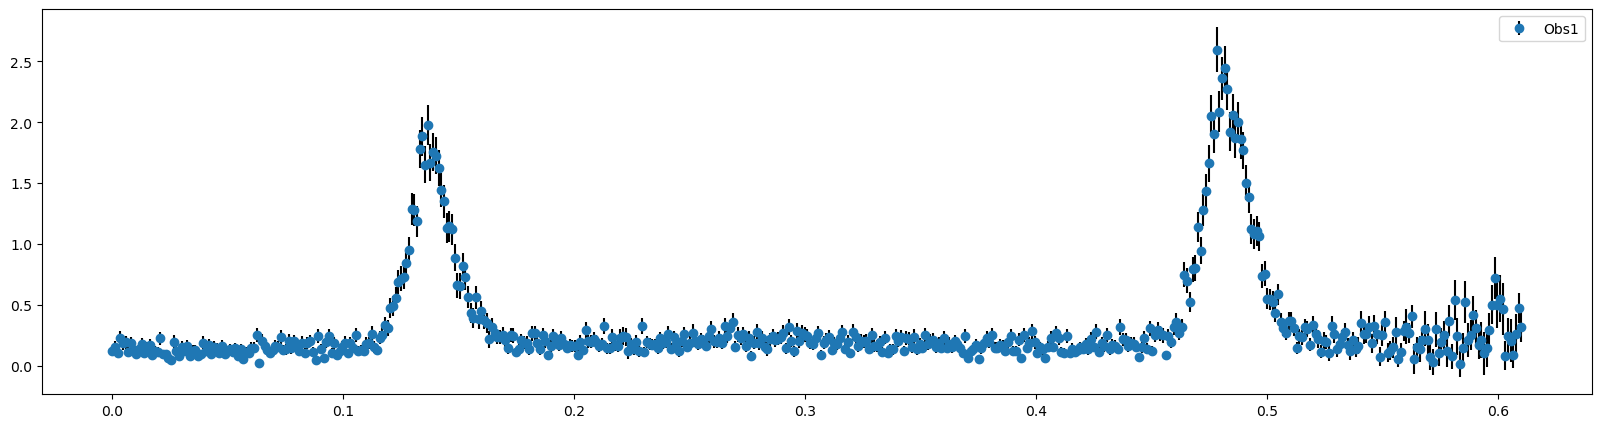

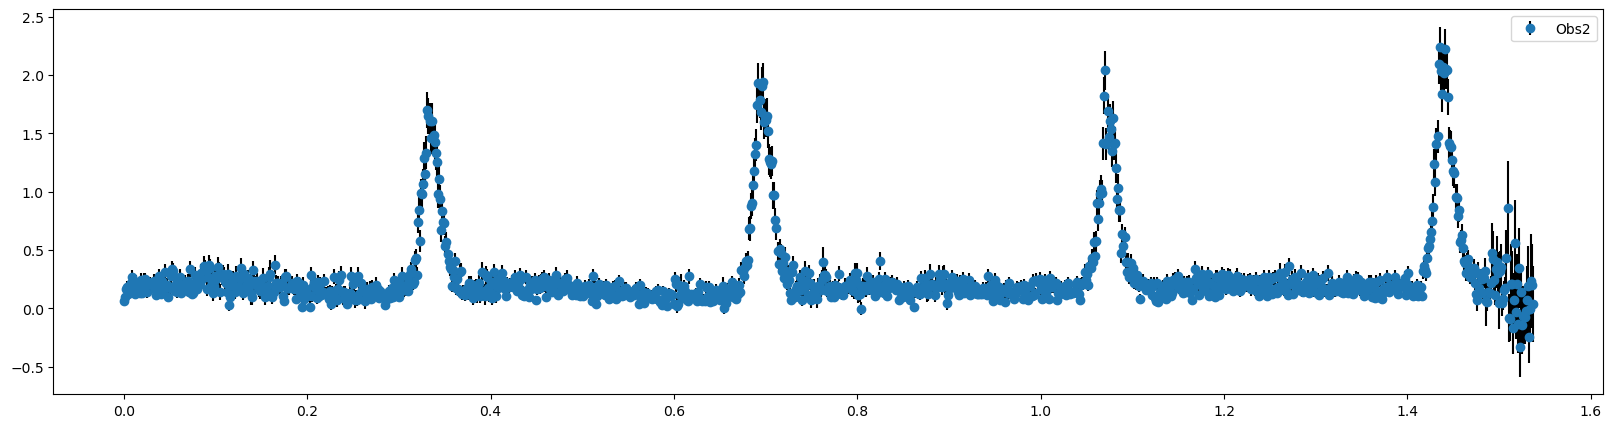

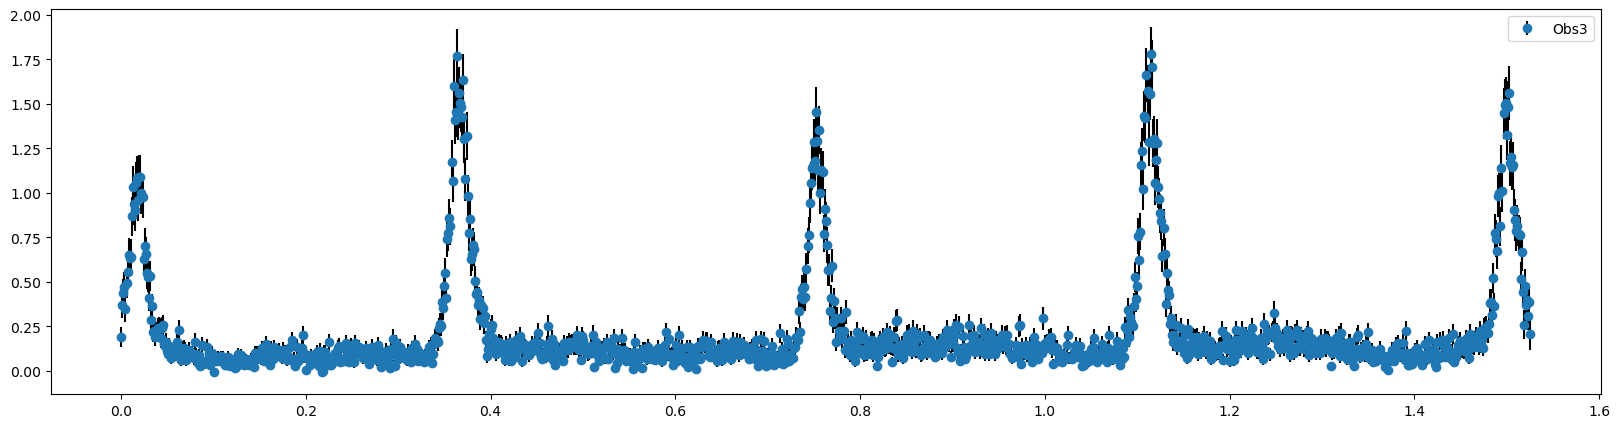

In [2]:
#some flags
onepeak_analyze = False #whether to perform nested sampling on the one-peak model
twopeak_analyze = False #whether to perform nested sampling on the two-peak model

#import data
filename = "GSN069"
os.makedirs(filename, exist_ok=True)

datafile = 'figure_data_GSN069'

runs = [
        'Obs1',
        'Obs2',
        'Obs3',
        #'Obs4',
       ]
start_times_MJD = []

datfile_name = [
    '0823680101.csv',
    '0831790701.csv',
    '0851180401.csv',
    #'0864330301.csv',
    ]

datadict = {} #dict with all data: 'time', 'rate', 'rate_err'

for i in range(len(runs)):

    run = runs[i]

    df = pd.read_csv(datafile+f'/{datfile_name[i]}', sep=',').to_numpy()

    if run not in ['Obs2']:
        time_raw = df[:,0] #in seconds
        time_raw /= (24 * 60 * 60) #now in days
        index_sorted = np.argsort(time_raw)
        time_offset = time_raw[index_sorted] - min(time_raw)
        time_units = TimeDelta(time_offset, format='jd')
        
        rate = df[:,1][index_sorted] #counts/sec
        rate_err = df[:,2][index_sorted] #1-sigma std in counts/sec

    else:
        # remove the half-flare in the beginning (20 odd points) - it's effing up the analysis for this run.
        time_raw = df[50:,0] #in seconds
        time_raw /= (24 * 60 * 60) #now in days
        index_sorted = np.argsort(time_raw)
        time_offset = time_raw[index_sorted] - min(time_raw)
        time_units = TimeDelta(time_offset, format='jd')
        
        rate = df[50:,1] #counts/sec
        rate_err = df[50:,2] #1-sigma std in counts/sec

    #some data-processing: make sure errors are not exactly zero (or worse, negative!) for any data point
    mask_zerorateerr = ~(rate_err > 0.0)
    rate_err[mask_zerorateerr] = np.mean(rate_err[~mask_zerorateerr]) #average of all other errors in that obs run
    
    datadict[run] = {'time':time_units, 'rate': rate, 'rate_err': rate_err}

    plt.figure(figsize=(20,5))
    plt.errorbar(time_units.value, rate, yerr=rate_err,ecolor='black',fmt='o', label=run)
    plt.legend()
    plt.savefig(f'{filename}/data_run_{run}.png',dpi=300,bbox_inches='tight')
    plt.show()

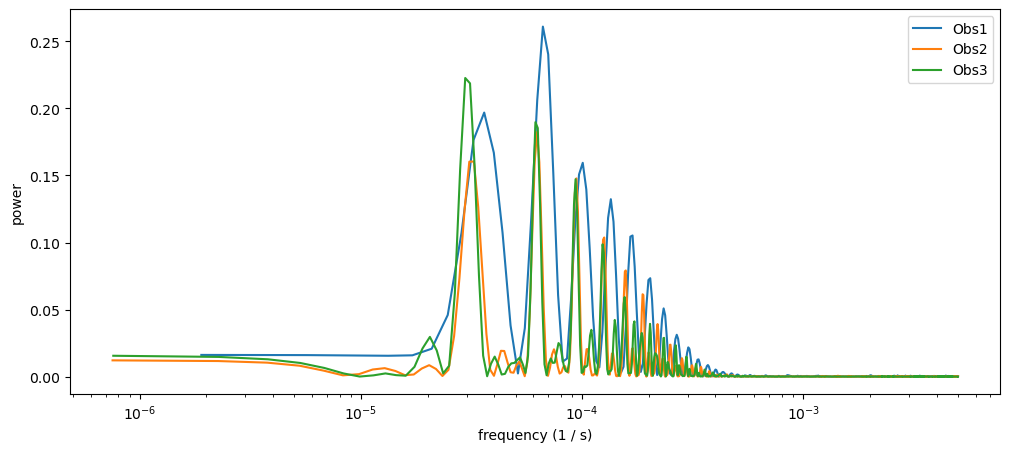

In [3]:
#Lomb-Scargle Periodograms and best period

minimum_expected_period = 2e2 * u.s #in sec. This is a fixed free parameter.

fig, ax = plt.subplots(figsize=(12,5))

for i in range(len(runs)):

    run = runs[i]
    time_units = datadict[run]['time']
    rate = datadict[run]['rate']
    
    frequency, power = LombScargle(time_units, rate).autopower() #in 1/days
    frequency = frequency / (24*60*60) * u.d/u.s #convert to 1/seconds
    period = 1 / frequency #in seconds
    
    #set a mask
    maximum_expected_frequency = 1/minimum_expected_period #in 1/sec

    #ignore period less that 2 x 10^2 (by eye)
    mask = frequency < maximum_expected_frequency
    frequency = frequency[mask]
    power = power[mask]

    #plot the frequency distribution
    
    ax.plot(frequency, power,label=run)

    ax.set_xlabel(f"frequency ({frequency.unit})")
    ax.set_ylabel("power")
    ax.set_xscale('log')

    #obtaining the best period
    ts = TimeSeries(time=time_units, data={'rate': rate})
    best_index = np.argmax(power) #maximum power
    best_period = period[best_index]  # in seconds

    #save best period in data dict
    datadict[run]['best_period'] = best_period
    
plt.legend()
plt.savefig(f'{filename}/periodogram.png',dpi=300,bbox_inches='tight')
plt.show()

0.17427248677248677 d
0.18518518518518523 d
0.39114434947768284 d


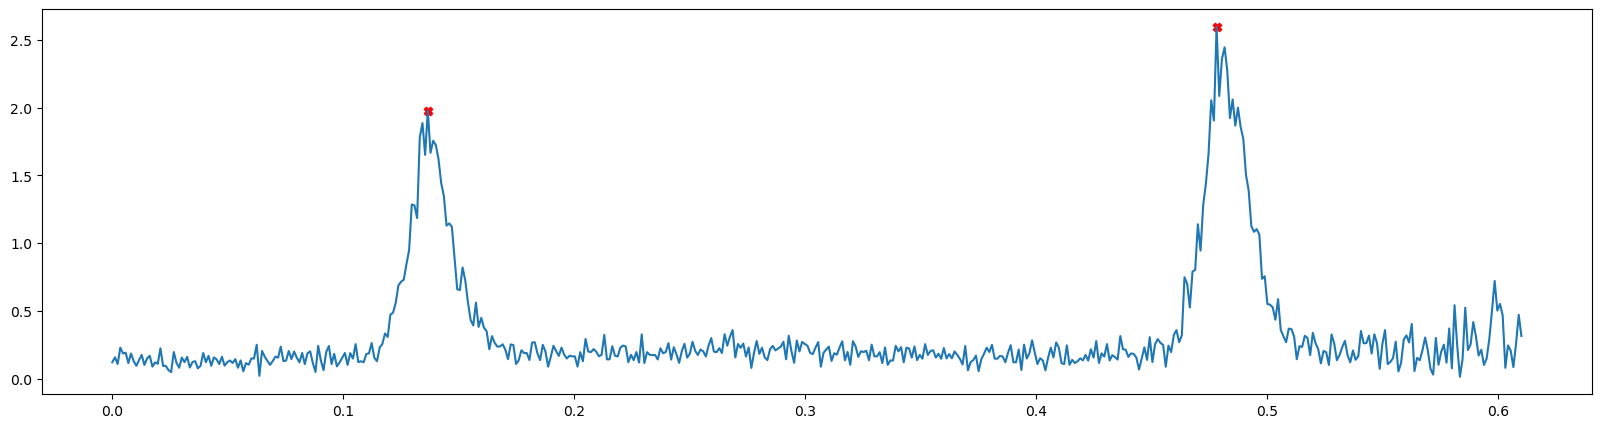

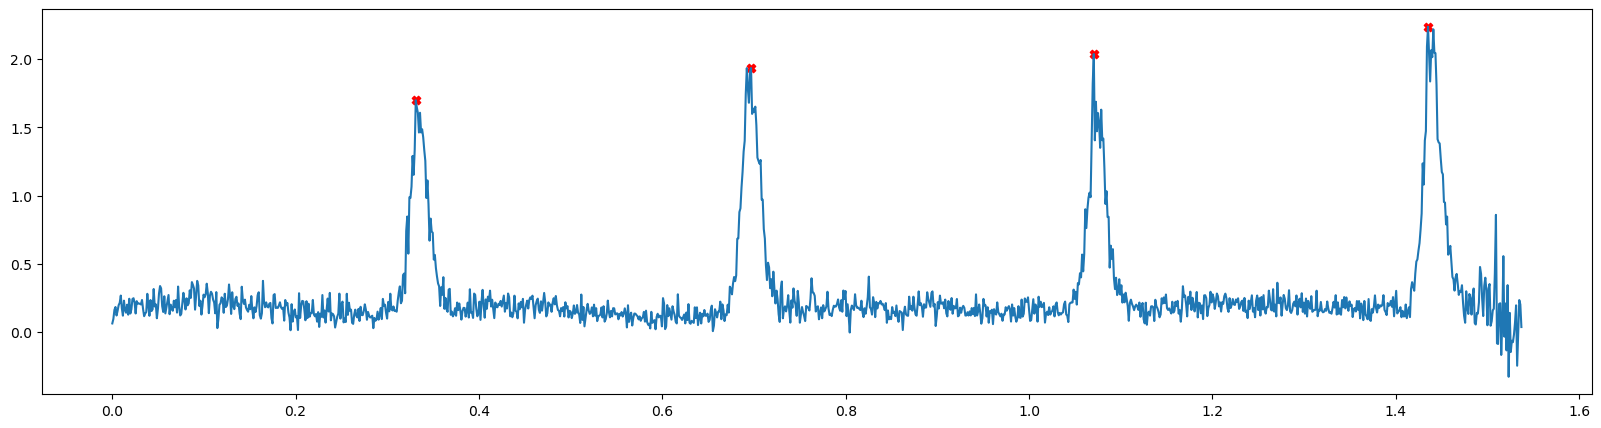

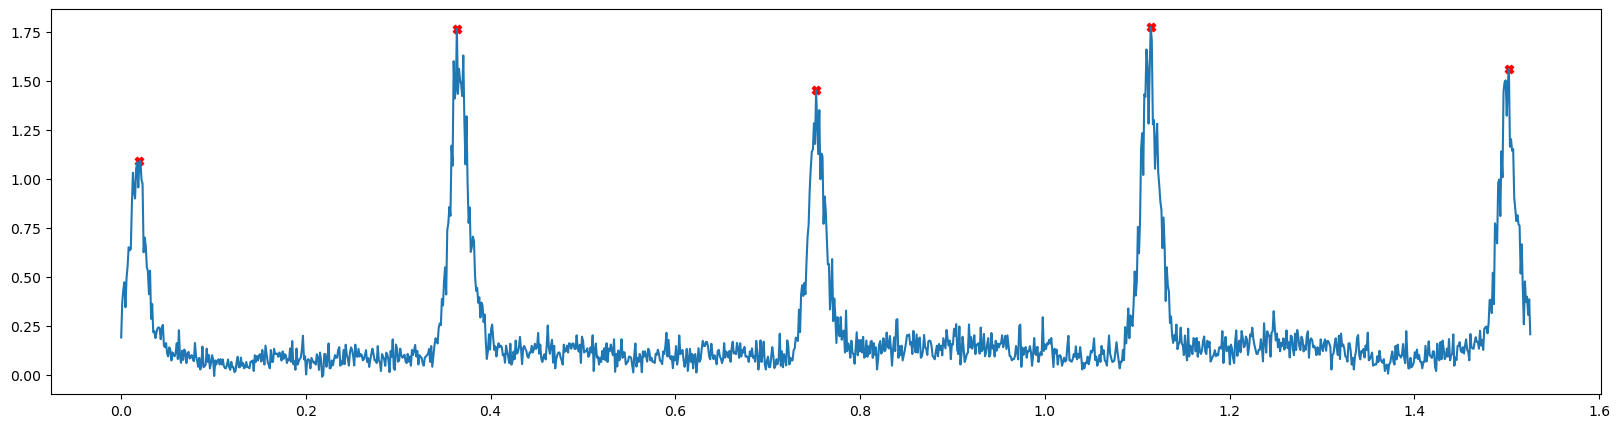

In [4]:


for i in range(len(runs)):

    run = runs[i]
    time_units = datadict[run]['time']
    rate = datadict[run]['rate']
    rate_err = datadict[run]['rate_err']
    best_period = datadict[run]['best_period'] #in seconds
    best_period_days = best_period.to('d')
    print(best_period_days)
    
    time_np = np.array(time_units.value)

    smoothed_counts = gaussian_filter1d(rate, sigma=np.mean(rate_err))

    plt.figure(figsize=(20,5))
    #plt.plot(time_np, rate)
    plt.plot(time_np, smoothed_counts)
    
    # Detect peaks
    dt = np.median(np.diff(time_np))
    distance = best_period_days.value / (dt) #distance in #samples
    peaks, _ = find_peaks(smoothed_counts, distance = distance/3, height = 1.0)
    plt.scatter(time_np[peaks], rate[peaks],c='r',marker='X')

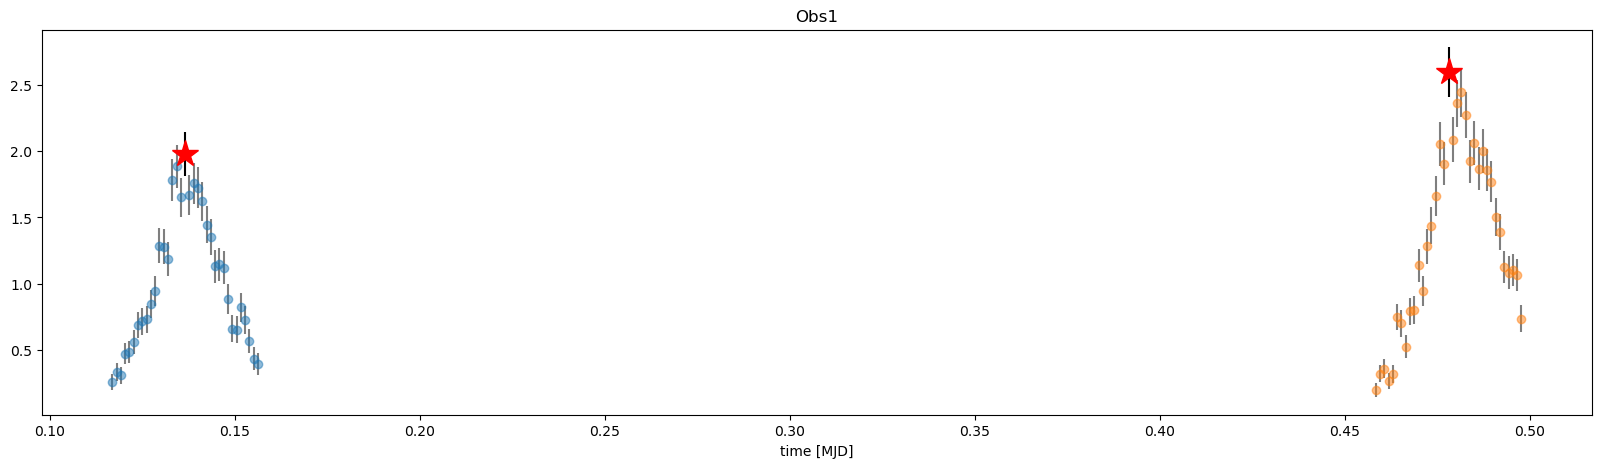

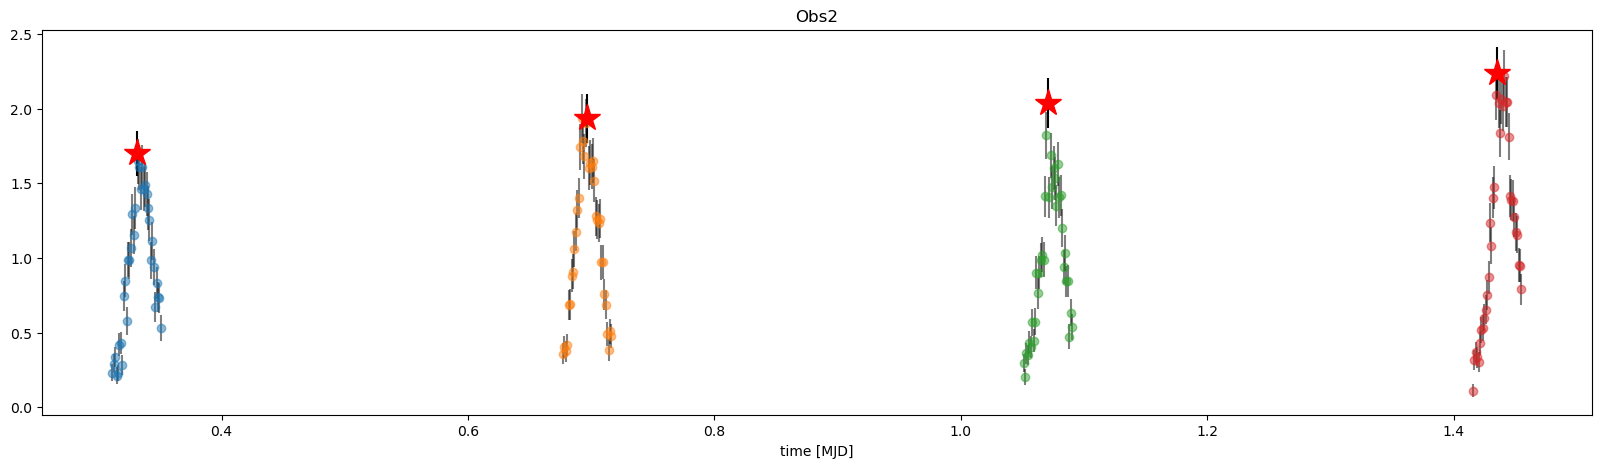

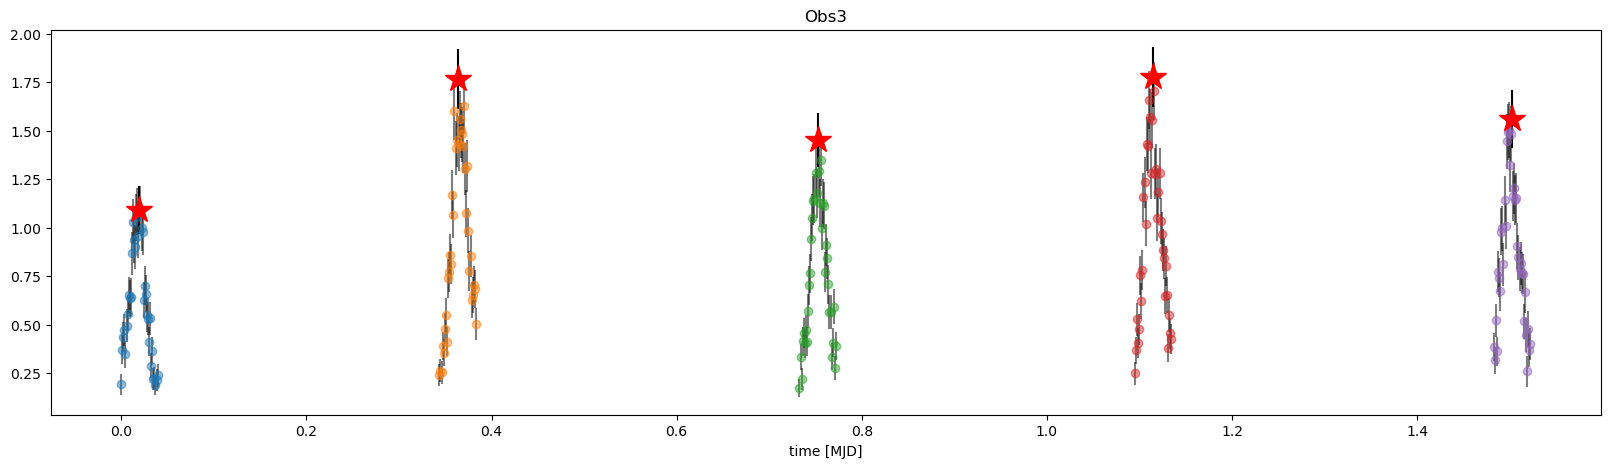

In [5]:
#explicit procedure to extract the nth peak (and data points around it) in a given observation run,

def nthpeakrange(time_range, rate_range, rate_err_range, best_period, time_around_peak, **find_peaks_kwargs):
    """
    given the reference starting time and arrays of times and rates in a given observation epoch, separate out all the peaks and output as n x time array where n is #peaks.
    
    args:
        time_range (astropy.Time object): 1D array of times in MJD of observed datapoints.
        rate_range (nd.array): 1D array of count rates of the oberved datapoints. Same shape as time_range.
        rate_err_range (nd.array): 1D array of standard deviations of the observed count rates. Same shape as time_range.
        best_period (astropy.Time object): best period inferred from the periodogram analysis (in seconds)
        time_around_peak (float): delta-time (in days) allowed around the peak in the output. This allows the user to exclude tails and enable better fits focused on the peaks.
        find_peak_kwargs (kwarg): kwargs for the scipy.signal.find_peaks function to assist in extracting individual peaks
        
    returns:
        time_nthpeakrange (astropy.Time object): 2D array of n x time in MJD around the nth peak
        rate_nthpeakrange (nd.array): 2D array of n x count rates around the nth peak
        rate_err_nthpeakrange (nd.array): 2D array of n x 1sigma errors of count rates around the nth peak
    """

    time_np = np.array(time_range.value) #convert to numpy

    smoothed_counts = gaussian_filter1d(rate_range, sigma=np.mean(rate_err_range))

    # Detect all the peaks
    if 'distance' not in list(find_peaks_kwargs.keys()):
        best_period_days = best_period.to('d')
        dt = np.median(np.diff(time_np))
        find_peaks_kwargs['distance'] = best_period_days.value / (dt) #distance in #samples

    index_peaks, _ = find_peaks(smoothed_counts, **find_peaks_kwargs)

    time_nthpeakrange = []
    rate_nthpeakrange = []
    rate_err_nthpeakrange = []
    
    for i in range(len(index_peaks)):

        #number index of peak
        n = i + 1
        
        #approximate nth peak datapoint's time
        index_nthpeak = index_peaks[i] #nth peak index
        time_nthpeak = time_range[index_nthpeak] 
                
        #set bounds around nth peak
        time_offset_peak = time_range - time_nthpeak #offset with respect to the peak
        mask_newrange = np.abs(time_offset_peak.value) < time_around_peak #mask for time allowed around peak.
        time_nthpeakrange.append(time_range[mask_newrange])
        rate_nthpeakrange.append(rate_range[mask_newrange])
        rate_err_nthpeakrange.append(rate_err_range[mask_newrange])
        
    return time_nthpeakrange, rate_nthpeakrange, rate_err_nthpeakrange


for i in range(len(runs)):

    run = runs[i]

    time_units = datadict[run]['time']
    rate = datadict[run]['rate']
    rate_err = datadict[run]['rate_err']    
    best_period = datadict[run]['best_period']

    plt.figure(figsize=(20,5))

    #set tuning params !!! ONLY TIME THIS IS NEEDED - SET BASED ON CHI-BY-EYE !!!

    time_around_peak = 0.02 #output range of time (in days) around the peak in the nth flare. None if you don't want to control this.

    find_peaks_kwargs = {'height':1.0}
    best_period_days = best_period.to('d')
    dt = np.median(np.diff(time_units.value))
    find_peaks_kwargs['distance'] = (best_period_days.value / dt)/3 #distance in #samples
    
    time_nthflare_all, rate_nthflare_all, rate_err_nthflare_all = nthpeakrange(time_units, rate, rate_err, best_period, time_around_peak, **find_peaks_kwargs)

    for i in range(len(time_nthflare_all)):
        #approximate first peak datapoint
        index_nthpeak = np.argmax(rate_nthflare_all[i])
        time_nthpeak = time_nthflare_all[i][index_nthpeak] #will be used as starting point of the phasing.
        rate_nthpeak = rate_nthflare_all[i][index_nthpeak]
        rate_err_nthpeak = rate_err_nthflare_all[i][index_nthpeak]
        
        plt.errorbar(time_nthflare_all[i].value[time_nthflare_all[i] != time_nthpeak], rate_nthflare_all[i][time_nthflare_all[i] != time_nthpeak], yerr=rate_err_nthflare_all[i][time_nthflare_all[i] != time_nthpeak], ecolor='black',fmt='o',alpha=0.5)
        plt.errorbar(time_nthpeak.value, rate_nthpeak, yerr=rate_err_nthpeak, ecolor='black',fmt='*', c='red',markersize=20)

    plt.title(run)
    plt.xlabel(f"time [MJD]") 
    plt.savefig(f'{filename}/individual_flares_run_{run}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
#phenomenological peak model - 1 peak

def onepeakmodel(t, A, tpeak, tau1, tau2):
    #Eq. (1) in Arcodia et al. (2022) https://arxiv.org/pdf/2203.11939
    
    t_lam = np.sqrt(tau1 / tau2)
    t_as = np.sqrt(tau1 * tau2)
    
    lam = np.exp(t_lam)
    
    if type(t) == float:
        delta = tpeak - t_as - t
        
        if t < tpeak:
            count = A * lam * np.exp(tau1 / delta)
        else:
            count = A * np.exp( - (t - tpeak) / tau2)

    else:

        count = []

        for i in range(len(t)):
            delta = tpeak - t_as - t[i]

            if t[i] < tpeak:
                
                if np.abs(delta) < 1e-3:
                    count.append(0.0)
                elif np.log(A) + np.log(lam) + tau1 / delta > 10.0:
                    count.append(0.0)
                else:
                    count.append(A * lam * np.exp(tau1 / delta))
            else:
                count.append(A * np.exp( - (t[i] - tpeak) / tau2))

        count = np.array(count)

    return count

In [7]:
#prior
def prior_transform_onepeak(u, Arange, tpeakrange, tau1range, tau2range):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = 2. * np.array(u) - 1 #u in range [-1,1]. Axes: [A, tpeak, tau1, tau2]

    x[0] = Arange[0] + (Arange[1] - Arange[0]) * u[0]
    x[1] = tpeakrange[0] + (tpeakrange[1] - tpeakrange[0]) * u[1]
    x[2] = tau1range[0] + (tau1range[1] - tau1range[0]) * u[2]
    x[3] = tau2range[0] + (tau2range[1] - tau2range[0]) * u[3]
    
    return x

class PriorTransformOnePeak:
    def __init__(self, Arange, tpeakrange, tau1range, tau2range,):
        self.Arange = Arange
        self.tpeakrange = tpeakrange
        self.tau1range = tau1range
        self.tau2range = tau2range

    def __call__(self, u):
        return prior_transform_onepeak(
            u,
            self.Arange, self.tpeakrange, self.tau1range, self.tau2range,
        )

#likelihood
def loglike_onepeak(x, time, data, dataerr):
    
    #dataerr are 1-sigma errors on luminosity measurements
    model = onepeakmodel(time, x[0], x[1], x[2], x[3])

    like = -0.5 * np.sum(((model - data)/dataerr)**2)

    if np.isnan(like):
        print(like)
        like = -np.inf
        
    return like

class LogLikeOnePeak:
    def __init__(self, time_in, rate_nthflare, rate_err_nthflare):
        self.time_in = time_in
        self.rate_nthflare = rate_nthflare
        self.rate_err_nthflare = rate_err_nthflare

    def __call__(self, x):
        return loglike_onepeak(x, self.time_in, self.rate_nthflare, self.rate_err_nthflare)

ndim = 4

pool = multiprocessing.Pool()

if onepeak_analyze:
    for i in range(len(runs)):
    
        run = runs[i]
    
        subfolder = f"run_{run}"
        subfolder = os.path.join(filename,subfolder)
        
        os.makedirs(subfolder, exist_ok=True)
        
        time_units = datadict[run]['time']
        rate = datadict[run]['rate']
        rate_err = datadict[run]['rate_err']
        
        best_period = datadict[run]['best_period']
        
        time_nthflare_all, rate_nthflare_all, rate_err_nthflare_all = nthpeakrange(time_units, rate, rate_err, best_period, time_around_peak, **find_peaks_kwargs)
    
        for ii in range(len(time_nthflare_all)):

            n = ii + 1
            print(f"Now inferring peak {n}.")
        
            time_nthflare, rate_nthflare, rate_err_nthflare = [time_nthflare_all[ii], rate_nthflare_all[ii], rate_err_nthflare_all[ii]]
    
            #approximate nth peak datapoint. These will be used in setting the prior
            index_nthpeak = np.argmax(rate_nthflare)
            time_nthpeak = time_nthflare[index_nthpeak] #will be used as starting point of the phasing.
            rate_nthpeak = rate_nthflare[index_nthpeak]
            rate_err_nthpeak = rate_err_nthflare[index_nthpeak]
                
            time_in = time_nthflare.value - time_nthflare.value[0] #time should be an array of days, starting from 0.0
            time_nthpeak_in = time_nthpeak.value - time_nthflare.value[0]
            
            #prior func (uniform priors)
            Arange = [rate_nthpeak*(0.9), rate_nthpeak*(1.1)] #amplitude in count/sec    
            tpeakrange = [0.0, max(time_in)] #tpeak in days
            tau1range = [0.1, 5] #will be refined over time
            tau2range = [1e-3, 0.1] #will be refined over time
    
            ptform_u_onepeak = PriorTransformOnePeak(Arange, tpeakrange, tau1range, tau2range)
        
            #loglike func
            loglike_x_onepeak = LogLikeOnePeak(time_in, rate_nthflare, rate_err_nthflare)
    
            # Sample from our distribution.
            dsampler = dynesty.DynamicNestedSampler(loglike_x_onepeak, ptform_u_onepeak, ndim=ndim,
                                            bound='single', sample='unif', pool=pool, queue_size=multiprocessing.cpu_count() )
        
            dsampler.run_nested(dlogz_init = 0.1)
            
            # Save to file
            with open(f"{subfolder}/results_onepeak_{n}.pkl", "wb") as f:
                pickle.dump(dsampler.results, f)

In [8]:
#fancy plots

for i in range(len(runs)):
    
    run = runs[i]

    subfolder = f"run_{run}"
    subfolder = os.path.join(filename,subfolder)
    
    os.makedirs(subfolder, exist_ok=True)
    
    time_units = datadict[run]['time']
    rate = datadict[run]['rate']
    rate_err = datadict[run]['rate_err']

    best_period = datadict[run]['best_period']
    
    time_nthflare_all, rate_nthflare_all, rate_err_nthflare_all = nthpeakrange(time_units, rate, rate_err, best_period, time_around_peak, **find_peaks_kwargs)
    
    for ii in range(len(time_nthflare_all)):

        n = ii + 1
        print(f"Now inferring peak {n}.")
    
        time_nthflare, rate_nthflare, rate_err_nthflare = [time_nthflare_all[ii], rate_nthflare_all[ii], rate_err_nthflare_all[ii]]

        #approximate first peak datapoint. These will be used in setting the prior
        index_nthpeak = np.argmax(rate_nthflare)
        time_nthpeak = time_nthflare[index_nthpeak] #will be used as starting point of the phasing.
        rate_nthpeak = rate_nthflare[index_nthpeak]
        rate_err_nthpeak = rate_err_nthflare[index_nthpeak]
            
        time_in = time_nthflare.value - time_nthflare.value[0] #time should be an array of days, starting from 0.0
        time_nthpeak_in = time_nthpeak.value - time_nthflare.value[0]

        # Load from file
        with open(f"{subfolder}/results_onepeak_{n}.pkl", "rb") as f:
            res = pickle.load(f)

        # Plot results.
        #fig, axes = dyplot.runplot(res)
    
        # Convert log-weights to linear weights
        logl = res.logl
        logwt = res.logwt
        logz = res.logz[-1]
        weights = np.exp(logwt - logz)
        samples = res.samples

        samples_weighted = dyfunc.resample_equal(samples, weights)
        loglike_weighted = dyfunc.resample_equal(logl, weights)
        
        #get 68% confidence interval
        sorted_indices = np.argsort(-loglike_weighted)
        cumulative_prob = np.cumsum(np.ones(len(sorted_indices)) / len(sorted_indices))  #each sample is already (re-)drawn proprtionately to the weights.
        mask = cumulative_prob <= 0.6827 #1-sigma
        samples_1sigma = samples_weighted[sorted_indices][mask]
        
        light_curves_onesigma = np.array([onepeakmodel(time_in, *theta) for theta in samples_1sigma])

        lower_1sigma_curve = np.min(light_curves_onesigma, axis=0)
        upper_1sigma_curve = np.max(light_curves_onesigma, axis=0)

        # Get index of MAP
        best_index = np.argmax(weights)
        best_params = res.samples[best_index]

        best_fit_curve = onepeakmodel(time_in, *best_params)

        plt.figure(figsize=(7,5))
        plt.errorbar(time_in, rate_nthflare, yerr=rate_err_nthflare, color = 'black', ecolor='black', alpha = 0.4, fmt='o')
        plt.plot(time_in, best_fit_curve, c='royalblue', linewidth = 3, alpha = 1.0)
        plt.fill_between(time_in, lower_1sigma_curve, upper_1sigma_curve, color='lightsteelblue', alpha=0.5)
        plt.xlabel('time [d]', fontsize=16)
        plt.ylabel(f'count $s^{-1}$', fontsize=16) 
        plt.savefig(f"{subfolder}/fit_onepeak_{n}.png", dpi = 300, bbox_inches = 'tight')
        plt.close()

Now inferring peak 1.
Now inferring peak 2.
Now inferring peak 1.
Now inferring peak 2.
Now inferring peak 3.
Now inferring peak 4.
Now inferring peak 1.
Now inferring peak 2.
Now inferring peak 3.
Now inferring peak 4.
Now inferring peak 5.


In [9]:
#calculating the ln-evidence in the one-peak model

lnZ_all_onepeak = []
lnZerr_all_onepeak = []

for i in range(len(runs)):
    run = runs[i]
    
    subfolder = f"run_{run}"
    subfolder = os.path.join(filename,subfolder)

    time_units = datadict[run]['time']
    rate = datadict[run]['rate']
    rate_err = datadict[run]['rate_err']

    lnZ_run_onepeak = 0.0
    lnZerr_run_onepeak = 0.0
    
    time_nthflare_all, rate_nthflare_all, rate_err_nthflare_all = nthpeakrange(time_units, rate, rate_err, best_period, time_around_peak, **find_peaks_kwargs)
    
    for ii in range(len(time_nthflare_all)):

        n = ii + 1
        
        # Load results from file
        with open(f"{subfolder}/results_onepeak_{n}.pkl", "rb") as f:
            res = pickle.load(f)

        lnZ_run_onepeak += res.logz[-1] #add the final estimated lnZ value
        lnZerr_run_onepeak += res.logzerr[-1] #add the final error on the estimated lnZ value

    lnZ_all_onepeak.append(lnZ_run_onepeak) #append the total estimated lnZ in the ith run
    lnZerr_all_onepeak.append(lnZerr_run_onepeak) #append the error in lnZ in the ith run

lnZ_all_onepeak = np.array(lnZ_all_onepeak)
lnZerr_all_onepeak = np.array(lnZerr_all_onepeak)

total_lnZ_onepeak = np.sum(lnZ_all_onepeak)
total_lnZerr_onepeak = np.sum(lnZerr_all_onepeak)

np.savetxt(f"{filename}/onepeak_lnZ.txt", [total_lnZ_onepeak, total_lnZerr_onepeak])
print(f"Estimated lnZ in the one-peak model: {total_lnZ_onepeak} +- ({total_lnZerr_onepeak})")

Estimated lnZ in the one-peak model: -377.34320614378055 +- (1.0015112780165465)


In [10]:
#repeating the analysis for the two-peak model

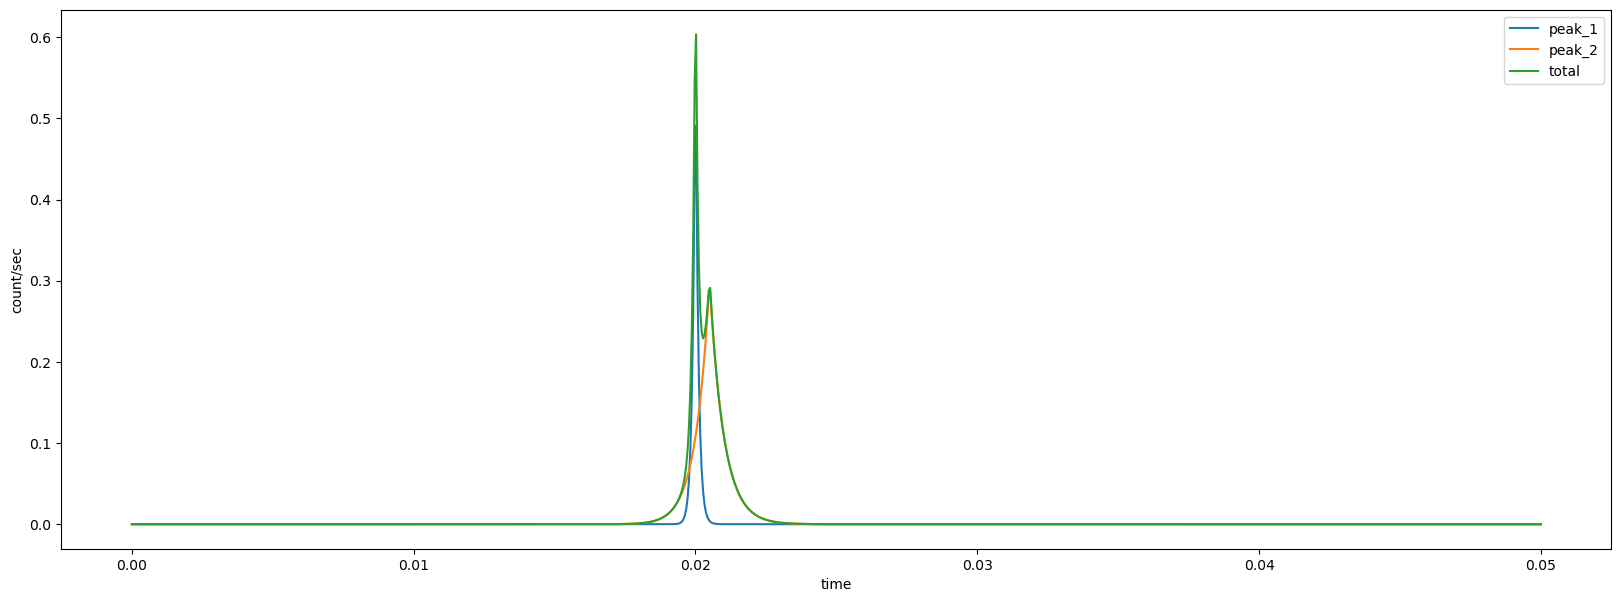

In [11]:
#phenomenological peak model - two peaks

def twopeakmodel(t, A_1, A_2, tpeak_1, delta_tpeak, tau1_1, tau1_2, tau2_1, tau2_2, return_individual = False):
    #Eq. (1) in Arcodia et al. (2022) https://arxiv.org/pdf/2203.11939

    tpeak_2 = tpeak_1 + delta_tpeak #tpeak_2 assumed to be > tpeak_1
    
    count_1 = onepeakmodel(t, A_1, tpeak_1, tau1_1, tau2_1)
    count_2 = onepeakmodel(t, A_2, tpeak_2, tau1_2, tau2_2)

    if return_individual:
        return count_1, count_2
    else:
        return count_1 + count_2

t = np.linspace(0.0,0.05,1000)

A_1 = 0.6
A_2 = 0.3
tpeak_1 = 0.02
delta_tpeak = 5e-4
tau1_1 = 0.4
tau1_2 = 1.0
tau2_1 = 0.0001
tau2_2 = 0.0005

plt.figure(figsize=(20,7))
plt.plot(t, twopeakmodel(t, A_1, A_2, tpeak_1, delta_tpeak, tau1_1, tau1_2, tau2_1, tau2_2, return_individual = True)[0],label='peak_1')
plt.plot(t, twopeakmodel(t, A_1, A_2, tpeak_1, delta_tpeak, tau1_1, tau1_2, tau2_1, tau2_2, return_individual = True)[1],label='peak_2')
plt.plot(t, twopeakmodel(t, A_1, A_2, tpeak_1, delta_tpeak, tau1_1, tau1_2, tau2_1, tau2_2),label='total')
plt.legend()
plt.xlabel('time')
plt.ylabel('count/sec')
plt.show()

In [12]:
#prior
def prior_transform_twopeak(u, Arange_1, Arange_2, tpeakrange_1, deltapeak_range, tau1range_1, tau1range_2, tau2range_1, tau2range_2):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = np.array(u) #u in range [0,1]. Axes: [A_1, A_2, tpeak_1, tpeak_2, tau1_1, tau1_2, tau2_1, tau2_2]

    x[0] = Arange_1[0] + (Arange_1[1] - Arange_1[0]) * u[0]
    x[1] = Arange_2[0] + (Arange_2[1] - Arange_2[0]) * u[1]
    
    x[2] = tpeakrange_1[0] + (tpeakrange_1[1] - tpeakrange_1[0]) * u[2]
    
    x[3] = deltapeak_range[0] + (deltapeak_range[1] - deltapeak_range[0]) * u[3]
    
    x[4] = tau1range_1[0] + (tau1range_1[1] - tau1range_1[0]) * u[4]
    x[5] = tau1range_2[0] + (tau1range_2[1] - tau1range_2[0]) * u[5]
    
    x[6] = tau2range_1[0] + (tau2range_1[1] - tau2range_1[0]) * u[6]
    x[7] = tau2range_2[0] + (tau2range_2[1] - tau2range_2[0]) * u[7]
    
    return x

class PriorTransformTwoPeak:
    def __init__(self, Arange_1, Arange_2, tpeakrange_1, delta_tpeak,
                 tau1range_1, tau1range_2, tau2range_1, tau2range_2):
        self.Arange_1 = Arange_1
        self.Arange_2 = Arange_2
        self.tpeakrange_1 = tpeakrange_1
        self.delta_tpeak = delta_tpeak
        self.tau1range_1 = tau1range_1
        self.tau1range_2 = tau1range_2
        self.tau2range_1 = tau2range_1
        self.tau2range_2 = tau2range_2

    def __call__(self, u):
        return prior_transform_twopeak(
            u,
            self.Arange_1, self.Arange_2,
            self.tpeakrange_1, self.delta_tpeak,
            self.tau1range_1, self.tau1range_2,
            self.tau2range_1, self.tau2range_2
        )

#likelihood
def loglike_twopeak(x, time, data, dataerr):
    
    #dataerr are 1-sigma errors on count rate measurements
    
    model = twopeakmodel(time, x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])

    like = -0.5 * np.sum(((model - data)/dataerr)**2)

    if np.isnan(like):
        print(like)
        like = -np.inf
        
    return like

class LogLikeTwoPeak:
    def __init__(self, time_in, rate_nthflare, rate_err_nthflare):
        self.time_in = time_in
        self.rate_nthflare = rate_nthflare
        self.rate_err_nthflare = rate_err_nthflare

    def __call__(self, x):
        return loglike_twopeak(x, self.time_in, self.rate_nthflare, self.rate_err_nthflare)

ndim = 4 + 4

pool = multiprocessing.Pool()

if twopeak_analyze:
    for i in range(len(runs)):
    
        run = runs[i]
    
        subfolder = f"run_{run}"
        subfolder = os.path.join(filename,subfolder)
        
        os.makedirs(subfolder, exist_ok=True)
        
        time_units = datadict[run]['time']
        rate = datadict[run]['rate']
        rate_err = datadict[run]['rate_err']
        
        best_period = datadict[run]['best_period']
        
        time_nthflare_all, rate_nthflare_all, rate_err_nthflare_all = nthpeakrange(time_units, rate, rate_err, best_period, time_around_peak, **find_peaks_kwargs)
        
        for ii in range(len(time_nthflare_all)):
    
            n = ii + 1
            print(f"Now inferring peak {n}.")
        
            time_nthflare, rate_nthflare, rate_err_nthflare = [time_nthflare_all[ii], rate_nthflare_all[ii], rate_err_nthflare_all[ii]]
    
            #approximate first peak datapoint. These will be used in setting the prior
            index_nthpeak = np.argmax(rate_nthflare)
            time_nthpeak = time_nthflare[index_nthpeak] #will be used as starting point of the phasing.
            rate_nthpeak = rate_nthflare[index_nthpeak]
            rate_err_nthpeak = rate_err_nthflare[index_nthpeak]
                
            time_in = time_nthflare.value - time_nthflare.value[0] #time should be an array of days, starting from 0.0
            time_nthpeak_in = time_nthpeak.value - time_nthflare.value[0]

            #prior func (uniform priors)
            Arange_1 = [rate_nthpeak/5, rate_nthpeak*(1.1)] #amplitude in count/sec    
            tpeakrange_1 = [0.0, max(time_in)] #[0.01, max(time_in) - 0.01] #tpeak in days
            tau1range_1 = [0.1, 5.0] #will be refined over time
            tau2range_1 = [1e-4, 0.02] #will be refined over time

            Arange_2 = [rate_nthpeak/5, rate_nthpeak*(1.1)] #amplitude in count/sec    
            delta_tpeak = [1e-4, 5e-3] #delta_tpeak = tpeak_2 - tpeak_1. Must be > 0.0.
            tau1range_2 = [0.1, 5.0] #will be refined over time
            tau2range_2 = [1e-4, 0.02] #will be refined over time
    
            ptform_u_twopeak = PriorTransformTwoPeak(
                                                    Arange_1, Arange_2, tpeakrange_1, delta_tpeak,
                                                    tau1range_1, tau1range_2, tau2range_1, tau2range_2
                                                )
        
            #loglike func
            loglike_x_twopeak = LogLikeTwoPeak(time_in, rate_nthflare, rate_err_nthflare)
    
            # Sample from our distribution.
            dsampler = dynesty.DynamicNestedSampler(loglike_x_twopeak, ptform_u_twopeak, ndim=ndim,
                                            bound='balls', sample='rwalk', pool=pool, queue_size=multiprocessing.cpu_count() )
        
            dsampler.run_nested(dlogz_init = 0.1)
            
            # Save to file
            with open(f"{subfolder}/results_twopeak_{n}.pkl", "wb") as f:
                pickle.dump(dsampler.results, f)

In [13]:
#fancy plots

for i in range(len(runs)):
    
    run = runs[i]

    subfolder = f"run_{run}"
    subfolder = os.path.join(filename,subfolder)
    
    os.makedirs(subfolder, exist_ok=True)
    
    time_units = datadict[run]['time']
    rate = datadict[run]['rate']
    rate_err = datadict[run]['rate_err']
    
    best_period = datadict[run]['best_period']
    
    time_nthflare_all, rate_nthflare_all, rate_err_nthflare_all = nthpeakrange(time_units, rate, rate_err, best_period, time_around_peak, **find_peaks_kwargs)
    
    for ii in range(len(time_nthflare_all)):

        n = ii + 1
        print(f"Now inferring peak {n}.")
    
        time_nthflare, rate_nthflare, rate_err_nthflare = [time_nthflare_all[ii], rate_nthflare_all[ii], rate_err_nthflare_all[ii]]

        #approximate first peak datapoint. These will be used in setting the prior
        index_nthpeak = np.argmax(rate_nthflare)
        time_nthpeak = time_nthflare[index_nthpeak] #will be used as starting point of the phasing.
        rate_nthpeak = rate_nthflare[index_nthpeak]
        rate_err_nthpeak = rate_err_nthflare[index_nthpeak]
            
        time_in = time_nthflare.value - time_nthflare.value[0] #time should be an array of days, starting from 0.0
        time_nthpeak_in = time_nthpeak.value - time_nthflare.value[0]

        # Load from file
        with open(f"{subfolder}/results_twopeak_{n}.pkl", "rb") as f:
            res = pickle.load(f)

        # Plot results.
        #fig, axes = dyplot.runplot(res)
    
        # Convert log-weights to linear weights
        logl = res.logl
        logwt = res.logwt
        logz = res.logz[-1]
        weights = np.exp(logwt - logz)
        samples = res.samples

        samples_weighted = dyfunc.resample_equal(samples, weights)
        loglike_weighted = dyfunc.resample_equal(logl, weights)
        
        #get 68% confidence interval
        sorted_indices = np.argsort(-loglike_weighted)
        cumulative_prob = np.cumsum(np.ones(len(sorted_indices)) / len(sorted_indices))  #each sample is already (re-)drawn proprtionately to the weights.
        mask = cumulative_prob <= 0.6827 #1-sigma
        samples_1sigma = samples_weighted[sorted_indices][mask]
        
        light_curves_onesigma = np.array([twopeakmodel(time_in, *theta) for theta in samples_1sigma])

        lower_1sigma_curve = np.min(light_curves_onesigma, axis=0)
        upper_1sigma_curve = np.max(light_curves_onesigma, axis=0)

        # Get index of MAP
        best_index = np.argmax(weights)
        best_params = res.samples[best_index]

        plt.figure(figsize=(7,5))
        plt.errorbar(time_in, rate_nthflare, yerr=rate_err_nthflare, color = 'black', ecolor='black', alpha = 0.4, fmt='o')
        plt.plot(time_in, twopeakmodel(time_in, *best_params), c='royalblue', linewidth = 3, alpha = 1.0)
        plt.fill_between(time_in, lower_1sigma_curve, upper_1sigma_curve, color='lightsteelblue', alpha=0.5)
        plt.plot(time_in, twopeakmodel(time_in, *best_params, return_individual = True)[0], c='crimson', alpha=0.6)
        plt.plot(time_in, twopeakmodel(time_in, *best_params, return_individual = True)[1], c='crimson', alpha=0.6)
        plt.xlabel('time [d]', fontsize=16)
        plt.ylabel(f'count $s^{-1}$', fontsize=16) 
        plt.savefig(f"{subfolder}/fit_twopeak_{n}.png", dpi = 300, bbox_inches = 'tight')
        plt.close()

Now inferring peak 1.
Now inferring peak 2.
Now inferring peak 1.
Now inferring peak 2.
Now inferring peak 3.
Now inferring peak 4.
Now inferring peak 1.
Now inferring peak 2.
Now inferring peak 3.
Now inferring peak 4.
Now inferring peak 5.


In [19]:
#calculating the ln-evidence in the two-peak model

lnZ_all_twopeak = []
lnZerr_all_twopeak = []

for i in range(len(runs)):
    run = runs[i]
    
    subfolder = f"run_{run}"
    subfolder = os.path.join(filename,subfolder)

    time_units = datadict[run]['time']
    rate = datadict[run]['rate']
    rate_err = datadict[run]['rate_err']
    
    best_period = datadict[run]['best_period']

    lnZ_run_twopeak = 0.0
    lnZerr_run_twopeak = 0.0
    
    time_nthflare_all, rate_nthflare_all, rate_err_nthflare_all = nthpeakrange(time_units, rate, rate_err, best_period, time_around_peak, **find_peaks_kwargs)
              
    for ii in range(len(time_nthflare_all)):

        n = ii + 1

        # Load results from file
        with open(f"{subfolder}/results_twopeak_{n}.pkl", "rb") as f:
            res = pickle.load(f)

        #Convert log-weights to linear weights
        logwt = res.logwt
        logz = res.logz[-1]
        weights = np.exp(logwt - logz)
        
        # Get index of MAP
        best_index = np.argmax(weights)
        best_params = res.samples[best_index]
        
        lnZ_run_twopeak += res.logz[-1] #add the final estimated lnZ value
        lnZerr_run_twopeak += res.logzerr[-1] #add the final error on the estimated lnZ value

    lnZ_all_twopeak.append(lnZ_run_twopeak) #append the total estimated lnZ in the ith run
    lnZerr_all_twopeak.append(lnZerr_run_twopeak) #append the error in lnZ in the ith run

lnZ_all_twopeak = np.array(lnZ_all_twopeak)
lnZerr_all_twopeak = np.array(lnZerr_all_twopeak)

total_lnZ_twopeak = np.sum(lnZ_all_twopeak)
total_lnZerr_twopeak = np.sum(lnZerr_all_twopeak)

np.savetxt(f"{filename}/twopeak_lnZ.txt", [total_lnZ_twopeak, total_lnZerr_twopeak])
print(f"Estimated lnZ in the two-peak model: {total_lnZ_twopeak} +- ({total_lnZerr_twopeak})")

Estimated lnZ in the two-peak model: -347.3295414014122 +- (1.0164951509357574)


In [21]:
#comparing one-peak and two-peak models

total_lnZ_onepeak = np.loadtxt(f"{filename}/onepeak_lnZ.txt")
total_lnZ_twopeak = np.loadtxt(f"{filename}/twopeak_lnZ.txt")
bf_one_to_two = total_lnZ_onepeak[0] - total_lnZ_twopeak[0]
bf_error = total_lnZ_onepeak[1] + total_lnZ_twopeak[1]

print(f"Estimated ln-Bayes Factor preferring the one-peak hypothesis: {bf_one_to_two} +- {bf_error}")

Estimated ln-Bayes Factor preferring the one-peak hypothesis: -30.01366474236835 +- 2.0180064289523036
